# Sparse inversion of gravity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import discretize
import simpeg
from simpeg import potential_fields

# Load data

In [2]:
df = pd.read_csv("gravity.csv", index_col=None)
df

,easting,northing,upward,gz,gz_std
0,-2000.0,-2000.0,10.0,-0.005701,0.004473
1,-1920.0,-2000.0,10.0,-0.012135,0.004473
2,-1840.0,-2000.0,10.0,-0.004569,0.004473
3,-1760.0,-2000.0,10.0,-0.004184,0.004473
4,-1680.0,-2000.0,10.0,-0.017608,0.004473
...,...,...,...,...,...
2596,1680.0,2000.0,10.0,-0.003344,0.004473
2597,1760.0,2000.0,10.0,-0.007108,0.004473
2598,1840.0,2000.0,10.0,-0.016486,0.004473
2599,1920.0,2000.0,10.0,-0.002839,0.004473


## Build mesh

In [3]:
hx = [(50.0, 256)]
hz = [(25.0, 256)]
mesh = discretize.TreeMesh(h=[hx, hx, hz], origin="CCN")
mesh.refine_box(x0s=(-3e3, -3e3, -3e3), x1s=(3e3, 3e3, 0), levels=3, finalize=False)
mesh.refine_box(x0s=(-2e3, -2e3, -2e3), x1s=(2e3, 2e3, 0), levels=6, finalize=False)
mesh.finalize()
mesh

OcTreeMesh: 0.09% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  2   :       28             ---------------------------   --------------------
  3   :       176         x:    -6400.0   ,   6400.0         200.0   ,   3200.0  
  4   :       536         y:    -6400.0   ,   6400.0         200.0   ,   3200.0  
  5   :      1296         z:    -6400.0   ,     0.0          100.0   ,   1600.0  
  6   :      12672     
-----------------------
Total :      14708

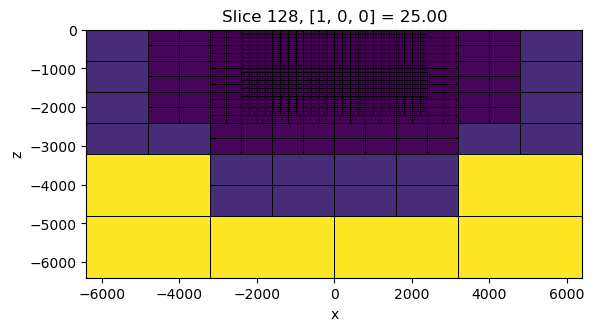

In [4]:
grid_opts = {"linewidth": 0.5, "color": "k"}

mesh.plot_slice(mesh.cell_volumes, normal="x", grid=True, grid_opts=grid_opts)
plt.gca().set_aspect("equal")
plt.show()

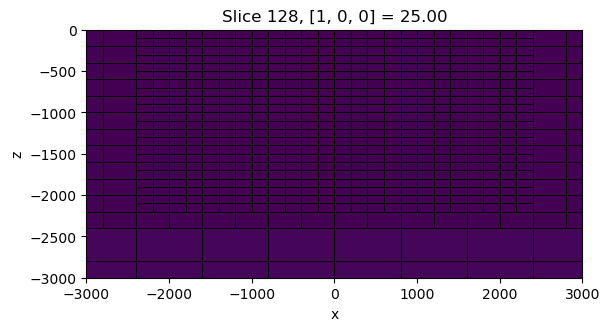

In [5]:
grid_opts = {"linewidth": 0.5, "color": "k"}

mesh.plot_slice(mesh.cell_volumes, normal="x", grid=True, grid_opts=grid_opts)
plt.gca().set_aspect("equal")
plt.xlim(-3e3, 3e3)
plt.ylim(-3e3, 0)
plt.show()

## Build survey

In [6]:
receiver_locations = np.vstack(
    (df.easting, df.northing, df.upward)
).T
receiver_locations

array([[-2000., -2000.,    10.],
       [-1920., -2000.,    10.],
       [-1840., -2000.,    10.],
       ...,
       [ 1840.,  2000.,    10.],
       [ 1920.,  2000.,    10.],
       [ 2000.,  2000.,    10.]])

In [7]:
receivers = potential_fields.gravity.Point(
    receiver_locations,
    components="gz",
)

source = potential_fields.gravity.SourceField(
    receiver_list=[receivers],
)

survey = potential_fields.gravity.Survey(source)

# Build simulation

In [8]:
mapping = simpeg.maps.IdentityMap(mesh)
gravity_simulation = potential_fields.gravity.Simulation3DIntegral(
    mesh=mesh,
    survey=survey,
    rhoMap=mapping,
    engine="choclo",
)

## Build data object

In [9]:
# Define gravity data object
gravity_data = simpeg.Data(
    survey,
    dobs=df.gz.values,
    standard_deviation=df.gz_std.values,
)

## Build mapping for the mesh

In [10]:
model_map = simpeg.maps.IdentityMap(mesh)

## Define the data misfit

In [11]:
data_misfit = simpeg.data_misfit.L2DataMisfit(
    data=gravity_data, simulation=gravity_simulation
)
data_misfit

## Define sparse regularization

Create reference model

In [12]:
reference_model = np.zeros(mesh.n_cells)

Define depth weighting to use in the regularization

In [13]:
depth_weights = simpeg.utils.depth_weighting(
    mesh,
    receivers.locations,
    exponent=2.0,
)

Build the regularization

In [14]:
regularization = simpeg.regularization.Sparse(
    mesh,
    mapping=model_map,
    weights={"depth_weights": depth_weights},
)
regularization.norms = [1, 2, 2, 2]

## Build the inversion

Define the optimization algorithm

In [15]:
optimization = simpeg.optimization.ProjectedGNCG(
    maxIter=50,    # max number of iterations
    lower=-1.0,    # bounds for the model parameters (in g/cc)
    upper=1.0,     # 
    maxIterLS=20,  # maximum number of iterations for line search
    maxIterCG=10,  # maximum number of iterations for the Conjugate Gradient
    tolCG=1e-3,    # tolerance for conj grad
)
optimization

Define inverse problem

In [16]:
inverse_problem = simpeg.inverse_problem.BaseInvProblem(
    data_misfit, regularization, optimization
)

Define directives

In [17]:
# Define a starting value for the trade-off parameter (beta)
starting_beta = simpeg.directives.BetaEstimate_ByEig(beta0_ratio=1)

# IRLS
update_IRLS = simpeg.directives.Update_IRLS(
    f_min_change=1e-4,
    max_irls_iterations=30,
    coolEpsFact=1.5,
    beta_tol=1e-2,
)

# Update the preconditionner if it is model dependent
update_jacobi = simpeg.directives.UpdatePreconditioner()

# Set a stopping criteria for the inversion
# target_misfit = simpeg.directives.TargetMisfit(chifact=1)

save_params = simpeg.directives.SaveOutputEveryIteration(save_txt=False)

In [18]:
# The directives are defined as a list.
directives = [
    update_IRLS,
    starting_beta,
    update_jacobi,
    # target_misfit,
    save_params,
]

Define inversion

In [19]:
inversion = simpeg.inversion.BaseInversion(inverse_problem, directives)

### Run inversion

In [20]:
inverted_model = inversion.run(reference_model)


Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.24e+01  1.60e+06  0.00e+00  1.60e+06    1.21e+02      0              
   1  1.12e+01  4.40e+05  1.18e+04  5.71e+05    1.21e+02      0              
   2  5.59e+00  2.71e+05  2.26e+04  3.97e+05    1.21e+02      0   Skip BFGS

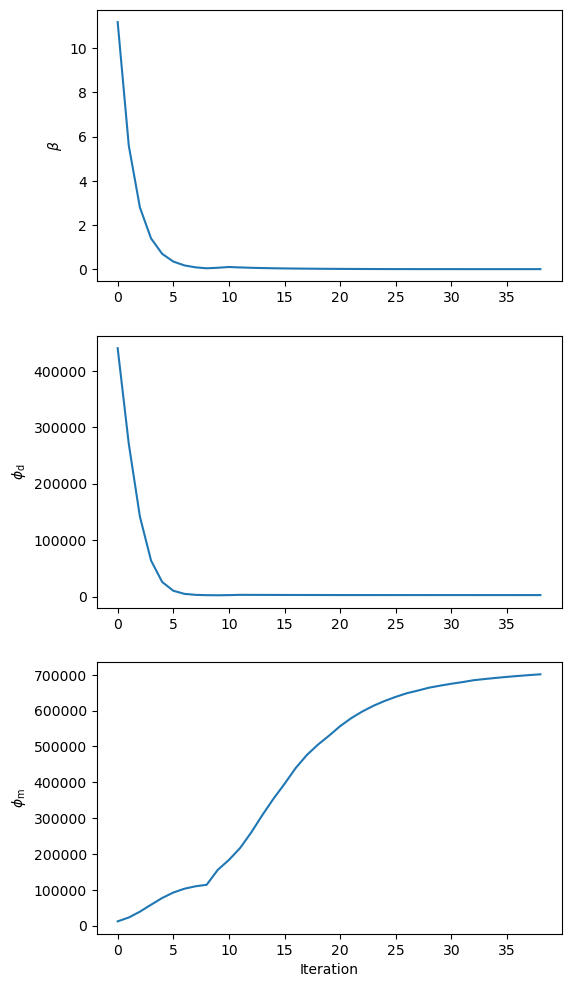

In [22]:
_, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))

axes[0].plot(save_params.beta)
axes[0].set_ylabel(r"$\beta$")

axes[1].plot(save_params.phi_d)
axes[1].set_ylabel(r"$\phi_\text{d}$")

axes[2].plot(save_params.phi_m)
axes[2].set_ylabel(r"$\phi_\text{m}$")

axes[-1].set_xlabel("Iteration")
plt.show()

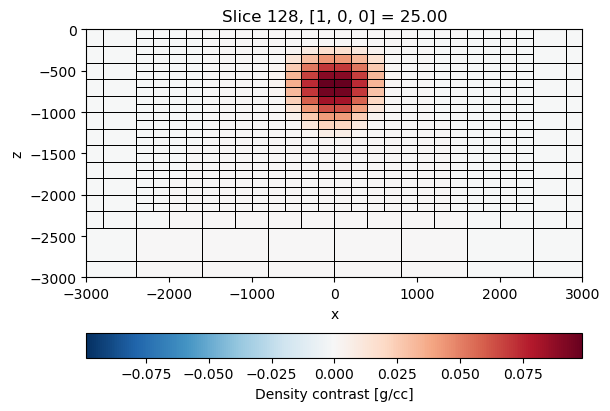

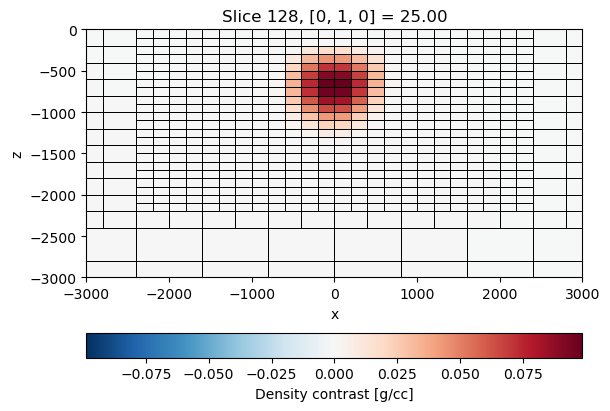

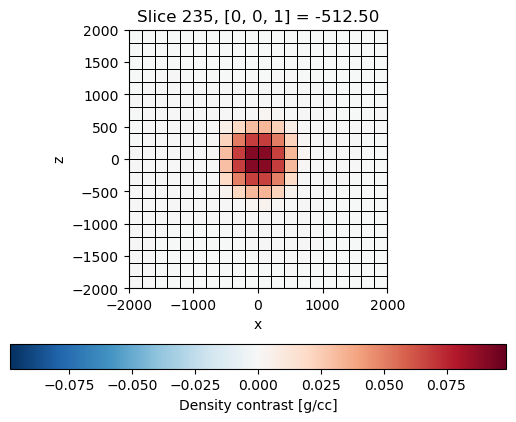

In [23]:
grid_opts = {"linewidth": 0.5, "color": "k"}

maxabs = np.max(np.abs(inverted_model))

for direction in ("x", "y", "z"):
    if direction == "z":
        kwargs = dict(slice_loc = -500)
    else:
        kwargs = dict()
    tmp, = mesh.plot_slice(
        inverted_model,
        normal=direction,
        grid=True,
        grid_opts=grid_opts,
        clim=(-maxabs, maxabs),
        pcolor_opts=dict(cmap="RdBu_r"),
        **kwargs,
    )
    plt.gca().set_aspect("equal")
    plt.colorbar(tmp, orientation="horizontal", label="Density contrast [g/cc]")
    if direction in ("x", "y"):
        plt.xlim(-3e3, 3e3)
        plt.ylim(-3e3, 0)
    else:
        plt.xlim(-2e3, 2e3)
        plt.ylim(-2e3, 2e3)
    plt.show()

## Check predicted data

In [27]:
gz_predicted = gravity_simulation.dpred(inverted_model)

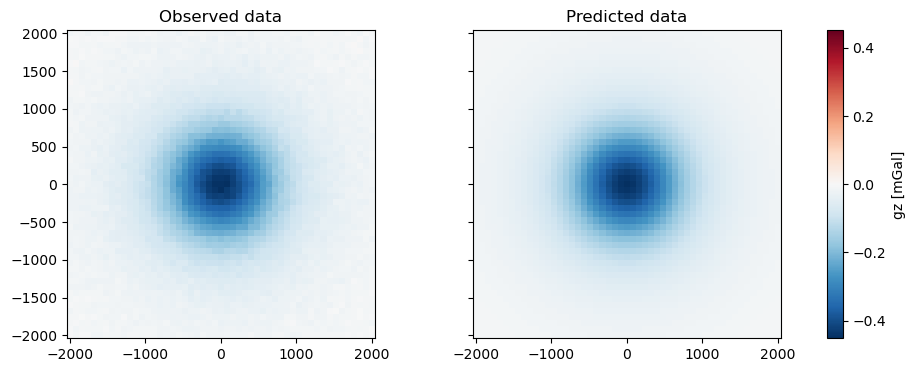

In [34]:
maxabs = max(np.max(np.abs(df.gz.values)), np.max(np.abs(gz_predicted))) 

shape = (51, 51)
easting = df.easting.values.reshape(shape)
northing = df.northing.values.reshape(shape)

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(
    easting,
    northing,
    df.gz.values.reshape(shape),
    cmap="RdBu_r",
    vmin=-maxabs,
    vmax=maxabs
)
ax2.pcolormesh(
    easting,
    northing,
    gz_predicted.reshape(shape),
    cmap="RdBu_r",
    vmin=-maxabs,
    vmax=maxabs
)
for ax in (ax1, ax2):
    ax.set_aspect("equal")
    
plt.colorbar(tmp, ax=(ax1, ax2), label="gz [mGal]")
ax1.set_title("Observed data")
ax2.set_title("Predicted data")

plt.show()

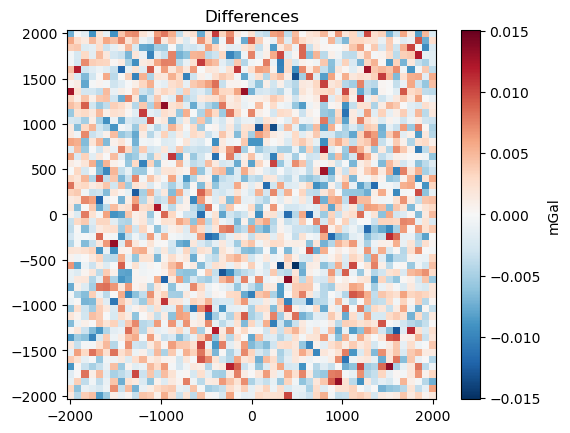

In [35]:
diff = df.gz.values - gz_predicted
maxabs = np.max(np.abs(diff))

plt.pcolormesh(
    easting,
    northing,
    diff.reshape(shape),
    cmap="RdBu_r",
    vmin=-maxabs,
    vmax=maxabs
)
plt.gca().set_aspect("equal")
plt.colorbar(label="mGal")
plt.title("Differences")
plt.show()